# VAR (Vector AutoRegression)
VAR PIPELINE

                                  Open         High          Low        Close  \
Date                                                                            
2024-01-01 00:00:00+05:30  1078.368009  1078.368009  1060.770676  1064.812622   
2024-01-02 00:00:00+05:30  1070.974097  1087.437802  1064.221074  1082.212769   
2024-01-03 00:00:00+05:30  1082.409874  1083.543621  1067.375718  1069.593872   
2024-01-04 00:00:00+05:30  1072.699249  1112.626021  1070.776898  1109.619263   
2024-01-05 00:00:00+05:30  1109.077063  1115.140042  1101.239634  1107.056030   
...                                ...          ...          ...          ...   
2024-12-27 00:00:00+05:30   895.364086   904.694956   892.386157   901.270325   
2024-12-30 00:00:00+05:30   901.270301   905.290494   892.088353   896.853027   
2024-12-31 00:00:00+05:30   892.386134   910.402630   886.529515   907.970642   
2025-01-01 00:00:00+05:30   906.283137   915.713246   904.297850   913.529419   
2025-01-02 00:00:00+05:30   

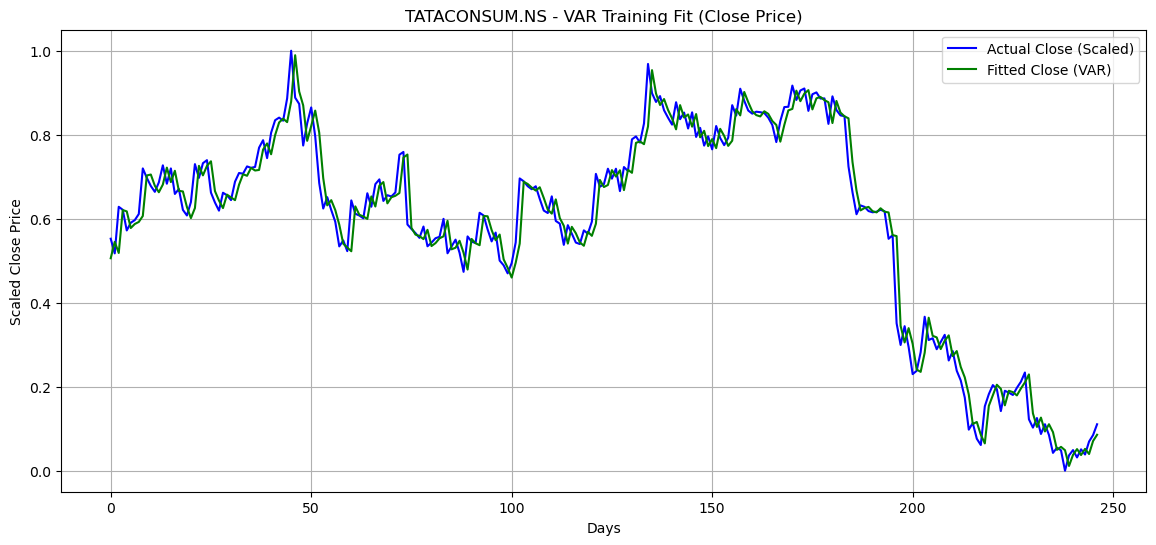


📈 NEXT 30 DAYS VAR FORECAST (REAL CLOSE PRICES)

Day +1: ₹922.10
Day +2: ₹923.08
Day +3: ₹923.94
Day +4: ₹924.82
Day +5: ₹925.70
Day +6: ₹926.57
Day +7: ₹927.43
Day +8: ₹928.28
Day +9: ₹929.13
Day +10: ₹929.96
Day +11: ₹930.80
Day +12: ₹931.62
Day +13: ₹932.44
Day +14: ₹933.25
Day +15: ₹934.05
Day +16: ₹934.85
Day +17: ₹935.64
Day +18: ₹936.42
Day +19: ₹937.20
Day +20: ₹937.97
Day +21: ₹938.73
Day +22: ₹939.49
Day +23: ₹940.24
Day +24: ₹940.99
Day +25: ₹941.73
Day +26: ₹942.46
Day +27: ₹943.18
Day +28: ₹943.90
Day +29: ₹944.62
Day +30: ₹945.32


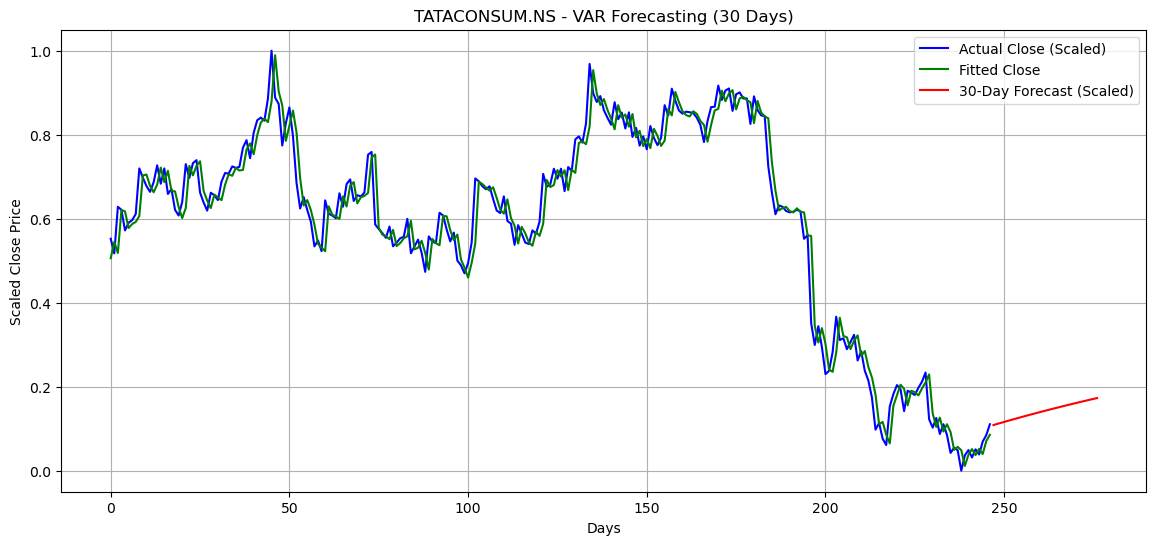

In [1]:
# ========================================================
# 0️⃣ IMPORT LIBRARIES
# ========================================================
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


# ========================================================
# 1️⃣ DOWNLOAD DATA
# ========================================================
ticker = yf.Ticker("TATACONSUM.NS")
stk_data = ticker.history(start="2024-01-01", end="2025-01-03")

print(stk_data)
stk_data.info()


# ========================================================
# 2️⃣ SELECT MULTIVARIATE FEATURES FOR VAR
# ========================================================
df = stk_data[["Open", "High", "Low", "Close", "Volume"]]

# Normalize all columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

print("\nScaled Data Shape:", scaled_df.shape)


# ========================================================
# RMSE + MAPE FUNCTION
# ========================================================
def rmsemape(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return rmse, mape


# ========================================================
# 3️⃣ TRAIN VAR MODEL
# ========================================================
print("\n==============================")
print("Training VAR Model...")
print("==============================\n")

model = VAR(scaled_df)

# Auto-select best lag (up to lag=10)
lag_selection = model.select_order(maxlags=10)
best_lag = lag_selection.aic  # using AIC criterion

print("Selected Lags (by AIC):")
print(lag_selection.summary())

lag = best_lag if best_lag is not None else 2
print(f"\n🔥 Best Lag chosen for VAR: {lag}")

var_model = model.fit(lag)
print(var_model.summary())


# ========================================================
# 4️⃣ FIT MODEL (Prediction on full dataset)
# ========================================================
fitted_values = var_model.fittedvalues

# Align actual and fitted for Close price
actual_close = scaled_df["Close"].iloc[lag:].values
pred_close = fitted_values["Close"].values

rmse, mape = rmsemape(actual_close, pred_close)

print("\n==============================")
print("VAR MODEL PERFORMANCE (Close)")
print("==============================")
print(f"RMSE : {rmse:.6f}")
print(f"MAPE : {mape:.6f}\n")


# ========================================================
# 5️⃣ PLOT ACTUAL vs FITTED (Close price)
# ========================================================
plt.figure(figsize=(14,6))
plt.plot(actual_close, label="Actual Close (Scaled)", color="blue")
plt.plot(pred_close, label="Fitted Close (VAR)", color="green")
plt.title("TATACONSUM.NS - VAR Training Fit (Close Price)")
plt.xlabel("Days")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid()
plt.show()


# ========================================================
# 6️⃣ FORECAST NEXT 30 DAYS
# ========================================================
future_steps = 30

# Last available values for forecasting
last_values = scaled_df.values[-lag:]

forecast_scaled = var_model.forecast(last_values, steps=future_steps)
forecast_scaled_df = pd.DataFrame(forecast_scaled, columns=df.columns)

# Convert only Close to real price
forecast_close_real = scaler.inverse_transform(
    np.hstack([
        np.zeros((future_steps, 4)),  # discard open/high/low for inverse
        forecast_scaled_df[["Volume"]].values  # dummy to maintain shape
    ])
)

# But we need Close real values separately:
real_full_inverse = scaler.inverse_transform(forecast_scaled_df)
forecast_real_close = real_full_inverse[:, 3]  # Close column


print("\n==============================")
print("📈 NEXT 30 DAYS VAR FORECAST (REAL CLOSE PRICES)")
print("==============================\n")

for i, price in enumerate(forecast_real_close):
    print(f"Day +{i+1}: ₹{price:.2f}")


# ========================================================
# 7️⃣ PLOT FORECAST
# ========================================================
plt.figure(figsize=(14,6))
plt.plot(actual_close, label="Actual Close (Scaled)", color="blue")
plt.plot(pred_close, label="Fitted Close", color="green")

forecast_index = range(len(actual_close), len(actual_close)+future_steps)
plt.plot(forecast_index, forecast_scaled_df["Close"], 
         label="30-Day Forecast (Scaled)", color="red")

plt.title("TATACONSUM.NS - VAR Forecasting (30 Days)")
plt.xlabel("Days")
plt.ylabel("Scaled Close Price")
plt.legend()
plt.grid()
plt.show()
